## Burger's Equation
\begin{equation}
u_t + uu_x = \nu u_{xx}, \quad x\in [-1,1],\ t\in(0,1] 
\end{equation}
We set $\nu=0.1/\pi$ and consider the periodic boundary condition here, i.e.:
$$
u(-1, t) = u(1, t),\quad t\in(0,1]
$$
The initial condition is $u(x,t=0)=a(x)$. Our goal is to learn a neural operator to predict the solution $u$ at $t=1$ given an initial condition $a(x)$, i.e.:
$$
\mathcal{G}: a(x) \rightarrow u(x,t=1)
$$

## (2) The Physics-informed MultiONet

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
random_seed = 10086 
setup_seed(random_seed)
device = 'cpu'
dtype = torch.float32
problem_name = 'Burgers_1d'
tag = 'tanhBeta64_TS'
######################################
# Load training data
######################################
data_train = h5py.File('../../Problems/Burgers_1d/viscid_train.mat', 'r')
data_test = h5py.File('../../Problems/Burgers_1d/viscid_test_in.mat', 'r')
print(data_train.keys())
print(data_test.keys())
######################################
from Utils.utils import *
n_train, n_test = 1000, 50
def get_data(data, ndata, dtype, n0=0):
    # Data is of the shape (number of samples = 1000, grid size = 29*29)
    a = np2tensor(np.array(data["u0"][...,n0:n0+ndata]).T, dtype)
    u = np2tensor(np.array(data["u_sol"][...,n0:n0+ndata]).T, dtype)
    uT = u[:,-1,:]
    #
    x_mesh = np.array(data['x_mesh']).T
    t_mesh = np.array(data['t_mesh']).T
    X, T = np.meshgrid(x_mesh, t_mesh)
    mesh = np2tensor(np.vstack([X.ravel(), T.ravel()]).T, dtype)
    grid_xt = mesh.reshape(-1, 2)
    #
    x = np2tensor(x_mesh).reshape(1, -1, 1).repeat(ndata,1,1)
    a = a.reshape(ndata, -1, 1)
    u = u.reshape(ndata, -1, 1)
    uT = uT.reshape(ndata, -1, 1)
    
    return a, u, uT, x, grid_xt
#
a_train, u_train, uT_train, x_train, gridxt_train = get_data(data_train, n_train, dtype)
a_test, u_test, uT_test, x_test, gridxt_test = get_data(data_test, n_test, dtype)
#
print('The shape of x_train:', x_train.shape)
print('The shape of a_train:', a_train.shape)
print('The shape of u_train:', u_train.shape)
print('The shape of uT_train:', uT_train.shape)
print('The shape of gridxt_train:', gridxt_train.shape)
#
print('The shape of x_test:', x_test.shape)
print('The shape of a_test:', a_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of uT_train:', uT_test.shape)
print('The shape of gridxt_test:', gridxt_test.shape)
######################################
# Generate training data
######################################
from Utils.GenPoints_Time import Point1D
pointGen = Point1D(x_lb=[-1.], x_ub=[1.], dataType=dtype, random_seed=random_seed)
#### Particles (centers of CSRBFs)
xc_train, tc_train, R_train = pointGen.weight_centers(
    n_center=1, nt=5000, Rmax=1e-4, Rmin=1e-4, method='hypercube')
####  (initial points)
xt_init = pointGen.init_point(num_sample=a_test.shape[1], t_stamp=[0.], method='mesh')
####  (initial points)
xt_end = pointGen.init_point(num_sample=uT_test.shape[1], t_stamp=[1.], method='mesh')
####  (boundary points)
xt_lb, xt_ub = pointGen.boundary_point(num_sample=500)

<KeysViewHDF5 ['t_mesh', 'u0', 'u_sol', 'x_mesh']>
<KeysViewHDF5 ['t_mesh', 'u0', 'u_sol', 'x_mesh']>
The shape of x_train: torch.Size([1000, 128, 1])
The shape of a_train: torch.Size([1000, 128, 1])
The shape of u_train: torch.Size([1000, 12928, 1])
The shape of uT_train: torch.Size([1000, 128, 1])
The shape of gridxt_train: torch.Size([12928, 2])
The shape of x_test: torch.Size([50, 128, 1])
The shape of a_test: torch.Size([50, 128, 1])
The shape of u_test: torch.Size([50, 12928, 1])
The shape of uT_train: torch.Size([50, 128, 1])
The shape of gridxt_test: torch.Size([12928, 2])


### (2.2) Define the loss class

In [2]:
import torch.nn as nn
from torch.autograd import grad, Variable
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
###############################
# The test function
###############################
int_grid, phi, dphi_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=1, n_mesh_or_grid=10, dataType=dtype).get_testFun()
print('The shape of int_grid', int_grid.shape, 'The shape of phi:', phi.shape)

######################################
## The mollifier (to satisfy the boundary condition)
######################################
class mollifer(object):

    def __inint__(self):
        super(mollifer, self).__init_()
        
    def __call__(self, u, xt):
        x= xt[...,0:1]
        u = u * torch.sin(np.pi*x/2. + np.pi/2.)
        return u

##################################
##### The loss Class
##################################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        ''' '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_enc = solver.model_dict['enc']
        self.model_u = solver.model_dict['u']
        self.mollifer = mollifer()
        ######################## 
        self.n_grid = int_grid.shape[0]
        self.int_grid = int_grid.to(self.device)
        
    def Loss_pde(self, a_batch, w_pde, nc=100, lamda=0.1/torch.pi):
        ''' PDE loss'''
        if w_pde>0.:
            n_batch = a_batch.shape[0]
            # ################################## 
            xc, tc, R = pointGen.weight_centers(n_center=1, nt=nc, Rmax=1e-4, Rmin=1e-4, method='hypercube')
            xc, tc, R = xc.to(self.device), tc.to(self.device), R.to(self.device)
            # 
            x = (self.int_grid * R + xc).reshape(-1, 1)
            t = tc.repeat(1, self.n_grid, 1).reshape(-1, 1)
            # 
            x = Variable(x.repeat((n_batch,1,1)), requires_grad=True) 
            t = Variable(t.repeat((n_batch,1,1)), requires_grad=True)  
            xt = torch.cat([x,t], dim=-1)
            ##########################################
            beta = self.model_enc(a_batch)
            u = self.model_u(xt, beta)
            u = self.mollifer(u, xt)
            du = grad(inputs=xt, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            dux, dut = du[...,0:1], du[...,1:2]
            #
            ddux = grad(inputs=xt, outputs=dux, grad_outputs=torch.ones_like(dux), create_graph=True)[0]
            duxx = ddux[...,0:1]
            ########################################### strong form
            res = dut + u * dux - lamda * duxx

            return self.solver.getLoss(res, torch.zeros_like(res))
        else:
            return torch.tensor(0.)
        
        return loss

    def Loss_data(self, x, a, u, w_data):
        n_batch = a.shape[0]
        ############### The initial condition
        xt = xt_init.repeat(n_batch, 1, 1).to(self.device)
        beta = self.model_enc(a)
        u_init = self.model_u(xt, beta)
        u_init = self.mollifer(u_init, xt)
        #
        loss_init = self.solver.getLoss(u_init, a)
        
        return loss_init
        
    def Error(self, x, a, u):
        n_batch = a.shape[0]
        ##################
        xt = gridxt_test.repeat(n_batch, 1, 1).to(self.device)
        beta = self.model_enc(a)
        u_all = self.model_u(xt, beta)
        u_all = self.mollifer(u_all, xt)
        #
        error = self.solver.getError(u_all, u)

        return error
        

######################################
# Steups of the model
######################################
from Solvers.PIMultiONet import PIMultiONet
solver = PIMultiONet.Solver(device=device, dtype=dtype)
netType = 'MultiONetBatch'
# ####################################### 
from Networks.EncoderNet import EncoderFCNet
#
class Encoder(nn.Module):
    def __init__(self, layers_beta, act_beta, dtype=None):
        super(Encoder, self).__init__()
        self.beta_net = EncoderFCNet(layers_beta, act_beta, dtype=dtype)
        
    def forward(self, x):
        '''
        Input:
            x: size(?, ny*nx, in_channel)
        Return:
            output: size(?, out_size)
        '''
        # size(n_batch, ny*nx, in_channel) -> size(n_batch, latent_size)
        beta = nn.Tanh()(self.beta_net(x))
        
        return beta
        
layers_beta = [a_train.shape[1], 128, 128, 64, 64, 64]
model_enc = Encoder(layers_beta, act_beta='ELU', dtype=dtype).to(device)

###################################### The u model (MultiONet)
hidden_list, act_x, act_a = [80]*6, 'Tanh_Sin', 'Tanh_Sin'
model_u = solver.getModel(x_in_size=2, a_in_size=64, hidden_list=hidden_list, 
                          activation_x=act_x, activation_a=act_a, netType=netType)

# ###############################
total_trainable_params_enc = sum(p.numel() for p in model_enc.parameters() if p.requires_grad)
print(f'{total_trainable_params_enc:,} training parameters.')
#
total_trainable_params_u = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params_u:,} training parameters.')
#
print(f'{total_trainable_params_enc + total_trainable_params_u:,} total parameters')

The shape of int_grid torch.Size([10, 1]) The shape of phi: torch.Size([10, 1])
49,600 training parameters.
83,212 training parameters.
132,812 total parameters


### (2.3) training and make prediction

#### (2.3.1) train the model

In [3]:
model_dict = {'u':model_u, 'enc':model_enc}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type='StepLR', 
                   gamma=1/3, step_size=2500)
solver.train(LossClass, a_train, u_train, x_train, a_test, u_test, x_test, 
             w_data=5000., w_pde=500., batch_size=50, epochs=10000, epoch_show=50,
             **{'save_path':f'saved_models/PI{netType}_{tag}/'})

  0%|▍                                                                            | 50/10000 [00:33<1:46:31,  1.56it/s]

Epoch:50 Time:33.5838, loss:4742.6031, loss_pde:3.0227, loss_data:0.6462
                l2_test:0.1452, lr:0.001


  1%|▊                                                                           | 100/10000 [01:07<1:51:17,  1.48it/s]

Epoch:100 Time:67.1601, loss:3608.4668, loss_pde:2.5544, loss_data:0.4663
                l2_test:0.0952, lr:0.001


  2%|█▏                                                                          | 150/10000 [01:40<1:51:27,  1.47it/s]

Epoch:150 Time:100.5400, loss:3567.4418, loss_pde:2.3813, loss_data:0.4754
                l2_test:0.0953, lr:0.001


  2%|█▌                                                                          | 200/10000 [02:14<1:49:56,  1.49it/s]

Epoch:200 Time:134.1383, loss:3062.4607, loss_pde:2.2391, loss_data:0.3886
                l2_test:0.0973, lr:0.001


  2%|█▉                                                                          | 250/10000 [02:47<1:48:25,  1.50it/s]

Epoch:250 Time:167.8502, loss:3081.4613, loss_pde:2.1762, loss_data:0.3987
                l2_test:0.1039, lr:0.001


  3%|██▎                                                                         | 300/10000 [03:21<1:49:24,  1.48it/s]

Epoch:300 Time:201.4005, loss:2758.5105, loss_pde:2.1162, loss_data:0.3401
                l2_test:0.0815, lr:0.001


  4%|██▋                                                                         | 350/10000 [03:55<1:46:44,  1.51it/s]

Epoch:350 Time:235.0576, loss:2731.5580, loss_pde:2.1391, loss_data:0.3324
                l2_test:0.0774, lr:0.001


  4%|███                                                                         | 400/10000 [04:29<1:49:00,  1.47it/s]

Epoch:400 Time:269.0155, loss:2483.5598, loss_pde:1.9312, loss_data:0.3036
                l2_test:0.0893, lr:0.001


  4%|███▍                                                                        | 450/10000 [05:02<1:46:24,  1.50it/s]

Epoch:450 Time:302.8926, loss:2509.6115, loss_pde:1.9706, loss_data:0.3049
                l2_test:0.0811, lr:0.001


  5%|███▊                                                                        | 500/10000 [05:36<1:45:48,  1.50it/s]

Epoch:500 Time:336.3201, loss:2472.4658, loss_pde:1.8849, loss_data:0.3060
                l2_test:0.0669, lr:0.001


  6%|████▏                                                                       | 550/10000 [06:10<1:47:57,  1.46it/s]

Epoch:550 Time:370.1908, loss:2508.0328, loss_pde:1.9028, loss_data:0.3113
                l2_test:0.0976, lr:0.001


  6%|████▌                                                                       | 600/10000 [06:43<1:47:25,  1.46it/s]

Epoch:600 Time:403.8442, loss:2212.4553, loss_pde:1.8815, loss_data:0.2543
                l2_test:0.0608, lr:0.001


  6%|████▉                                                                       | 650/10000 [07:17<1:44:05,  1.50it/s]

Epoch:650 Time:437.4584, loss:2081.1785, loss_pde:1.7021, loss_data:0.2460
                l2_test:0.0518, lr:0.001


  7%|█████▎                                                                      | 700/10000 [07:50<1:44:45,  1.48it/s]

Epoch:700 Time:470.9098, loss:2277.2166, loss_pde:1.7913, loss_data:0.2763
                l2_test:0.0645, lr:0.001


  8%|█████▋                                                                      | 750/10000 [08:24<1:44:22,  1.48it/s]

Epoch:750 Time:504.6110, loss:2346.0555, loss_pde:1.8003, loss_data:0.2892
                l2_test:0.0681, lr:0.001


  8%|██████                                                                      | 800/10000 [08:58<1:42:35,  1.49it/s]

Epoch:800 Time:538.1818, loss:2144.7564, loss_pde:1.6639, loss_data:0.2626
                l2_test:0.0520, lr:0.001


  8%|██████▍                                                                     | 850/10000 [09:32<1:47:52,  1.41it/s]

Epoch:850 Time:572.6202, loss:2131.4879, loss_pde:1.7065, loss_data:0.2557
                l2_test:0.0518, lr:0.001


  9%|██████▊                                                                     | 900/10000 [10:06<1:43:02,  1.47it/s]

Epoch:900 Time:606.4291, loss:2347.6898, loss_pde:1.8127, loss_data:0.2883
                l2_test:0.0762, lr:0.001


 10%|███████▏                                                                    | 950/10000 [10:40<1:42:50,  1.47it/s]

Epoch:950 Time:640.2457, loss:2063.9189, loss_pde:1.6977, loss_data:0.2430
                l2_test:0.0590, lr:0.001


 10%|███████▌                                                                   | 1000/10000 [11:14<1:43:41,  1.45it/s]

Epoch:1000 Time:674.2702, loss:1913.4785, loss_pde:1.6267, loss_data:0.2200
                l2_test:0.0539, lr:0.001


 10%|███████▉                                                                   | 1050/10000 [11:48<1:41:49,  1.46it/s]

Epoch:1050 Time:708.2907, loss:2018.5158, loss_pde:1.7035, loss_data:0.2334
                l2_test:0.0501, lr:0.001


 11%|████████▎                                                                  | 1100/10000 [12:22<1:40:45,  1.47it/s]

Epoch:1100 Time:742.0656, loss:1953.8545, loss_pde:1.6980, loss_data:0.2210
                l2_test:0.0462, lr:0.001


 12%|████████▋                                                                  | 1150/10000 [12:55<1:39:35,  1.48it/s]

Epoch:1150 Time:775.8182, loss:1901.9467, loss_pde:1.5592, loss_data:0.2245
                l2_test:0.0647, lr:0.001


 12%|█████████                                                                  | 1200/10000 [13:29<1:38:13,  1.49it/s]

Epoch:1200 Time:809.3980, loss:2037.9309, loss_pde:1.6027, loss_data:0.2473
                l2_test:0.0687, lr:0.001


 12%|█████████▍                                                                 | 1250/10000 [14:03<1:37:38,  1.49it/s]

Epoch:1250 Time:843.1155, loss:1858.1117, loss_pde:1.5979, loss_data:0.2118
                l2_test:0.0590, lr:0.001


 13%|█████████▊                                                                 | 1300/10000 [14:36<1:38:08,  1.48it/s]

Epoch:1300 Time:876.6842, loss:1869.5148, loss_pde:1.5808, loss_data:0.2158
                l2_test:0.0516, lr:0.001


 14%|██████████▏                                                                | 1350/10000 [15:10<1:37:04,  1.49it/s]

Epoch:1350 Time:910.4876, loss:1758.2957, loss_pde:1.5324, loss_data:0.1984
                l2_test:0.0413, lr:0.001


 14%|██████████▌                                                                | 1400/10000 [15:44<1:35:58,  1.49it/s]

Epoch:1400 Time:944.0824, loss:1992.4699, loss_pde:1.6590, loss_data:0.2326
                l2_test:0.0589, lr:0.001


 14%|██████████▉                                                                | 1450/10000 [16:17<1:35:14,  1.50it/s]

Epoch:1450 Time:977.9696, loss:1737.4813, loss_pde:1.4893, loss_data:0.1986
                l2_test:0.0517, lr:0.001


 15%|███████████▎                                                               | 1500/10000 [16:51<1:35:07,  1.49it/s]

Epoch:1500 Time:1012.0019, loss:1802.8559, loss_pde:1.5459, loss_data:0.2060
                l2_test:0.0518, lr:0.001


 16%|███████████▋                                                               | 1550/10000 [17:26<1:35:46,  1.47it/s]

Epoch:1550 Time:1046.0979, loss:1742.2127, loss_pde:1.4950, loss_data:0.1989
                l2_test:0.0469, lr:0.001


 16%|████████████                                                               | 1600/10000 [17:59<1:37:08,  1.44it/s]

Epoch:1600 Time:1079.9675, loss:1744.4535, loss_pde:1.4680, loss_data:0.2021
                l2_test:0.0469, lr:0.001


 16%|████████████▍                                                              | 1650/10000 [18:33<1:33:05,  1.49it/s]

Epoch:1650 Time:1113.9108, loss:1742.8707, loss_pde:1.5073, loss_data:0.1978
                l2_test:0.0591, lr:0.001


 17%|████████████▊                                                              | 1700/10000 [19:07<1:34:16,  1.47it/s]

Epoch:1700 Time:1147.4168, loss:1728.6059, loss_pde:1.5002, loss_data:0.1957
                l2_test:0.0593, lr:0.001


 18%|█████████████▏                                                             | 1750/10000 [19:41<1:31:48,  1.50it/s]

Epoch:1750 Time:1181.0954, loss:1827.0023, loss_pde:1.6113, loss_data:0.2043
                l2_test:0.0705, lr:0.001


 18%|█████████████▌                                                             | 1800/10000 [20:14<1:30:50,  1.50it/s]

Epoch:1800 Time:1214.6703, loss:1681.7482, loss_pde:1.5022, loss_data:0.1861
                l2_test:0.0407, lr:0.001


 18%|█████████████▉                                                             | 1850/10000 [20:48<1:31:35,  1.48it/s]

Epoch:1850 Time:1248.2049, loss:1687.6238, loss_pde:1.4739, loss_data:0.1901
                l2_test:0.0573, lr:0.001


 19%|██████████████▎                                                            | 1900/10000 [21:22<1:31:56,  1.47it/s]

Epoch:1900 Time:1282.3147, loss:1813.2760, loss_pde:1.6358, loss_data:0.1991
                l2_test:0.0472, lr:0.001


 20%|██████████████▋                                                            | 1950/10000 [21:56<1:28:57,  1.51it/s]

Epoch:1950 Time:1316.1956, loss:1700.3701, loss_pde:1.4728, loss_data:0.1928
                l2_test:0.0481, lr:0.001


 20%|███████████████                                                            | 2000/10000 [22:29<1:29:13,  1.49it/s]

Epoch:2000 Time:1349.7854, loss:1663.9625, loss_pde:1.4644, loss_data:0.1864
                l2_test:0.0453, lr:0.001


 20%|███████████████▎                                                           | 2050/10000 [23:03<1:30:00,  1.47it/s]

Epoch:2050 Time:1383.3342, loss:1737.1762, loss_pde:1.4325, loss_data:0.2042
                l2_test:0.0609, lr:0.001


 21%|███████████████▊                                                           | 2100/10000 [23:37<1:28:43,  1.48it/s]

Epoch:2100 Time:1417.2521, loss:1671.5738, loss_pde:1.3994, loss_data:0.1944
                l2_test:0.0489, lr:0.001


 22%|████████████████▏                                                          | 2150/10000 [24:11<1:31:07,  1.44it/s]

Epoch:2150 Time:1451.0950, loss:1643.0125, loss_pde:1.4271, loss_data:0.1859
                l2_test:0.0450, lr:0.001


 22%|████████████████▌                                                          | 2200/10000 [24:45<1:28:34,  1.47it/s]

Epoch:2200 Time:1485.2962, loss:1703.1035, loss_pde:1.5169, loss_data:0.1889
                l2_test:0.0485, lr:0.001


 22%|████████████████▉                                                          | 2250/10000 [25:19<1:30:01,  1.43it/s]

Epoch:2250 Time:1519.1665, loss:1559.8045, loss_pde:1.3999, loss_data:0.1720
                l2_test:0.0403, lr:0.001


 23%|█████████████████▎                                                         | 2300/10000 [25:53<1:27:17,  1.47it/s]

Epoch:2300 Time:1553.1148, loss:1581.1484, loss_pde:1.3243, loss_data:0.1838
                l2_test:0.0421, lr:0.001


 24%|█████████████████▋                                                         | 2350/10000 [26:27<1:25:27,  1.49it/s]

Epoch:2350 Time:1587.1465, loss:1640.7670, loss_pde:1.4529, loss_data:0.1829
                l2_test:0.0448, lr:0.001


 24%|██████████████████                                                         | 2400/10000 [27:00<1:25:44,  1.48it/s]

Epoch:2400 Time:1620.9218, loss:1724.9074, loss_pde:1.3835, loss_data:0.2066
                l2_test:0.0569, lr:0.001


 24%|██████████████████▍                                                        | 2450/10000 [27:34<1:25:19,  1.47it/s]

Epoch:2450 Time:1654.5314, loss:1578.1005, loss_pde:1.3665, loss_data:0.1790
                l2_test:0.0597, lr:0.001


 25%|██████████████████▊                                                        | 2500/10000 [28:08<1:26:07,  1.45it/s]

Epoch:2500 Time:1688.7366, loss:1735.7832, loss_pde:1.4611, loss_data:0.2010
                l2_test:0.0467, lr:0.0003333333333333333


 26%|███████████████████▏                                                       | 2550/10000 [28:42<1:25:20,  1.45it/s]

Epoch:2550 Time:1722.7755, loss:1050.4779, loss_pde:0.9327, loss_data:0.1168
                l2_test:0.0218, lr:0.0003333333333333333


 26%|███████████████████▌                                                       | 2600/10000 [29:16<1:23:10,  1.48it/s]

Epoch:2600 Time:1756.8112, loss:1047.8048, loss_pde:0.9278, loss_data:0.1168
                l2_test:0.0190, lr:0.0003333333333333333


 26%|███████████████████▉                                                       | 2650/10000 [29:50<1:23:07,  1.47it/s]

Epoch:2650 Time:1790.6761, loss:1031.3475, loss_pde:0.9612, loss_data:0.1101
                l2_test:0.0196, lr:0.0003333333333333333


 27%|████████████████████▎                                                      | 2700/10000 [30:24<1:22:21,  1.48it/s]

Epoch:2700 Time:1824.5386, loss:1010.5106, loss_pde:0.8913, loss_data:0.1130
                l2_test:0.0225, lr:0.0003333333333333333


 28%|████████████████████▋                                                      | 2750/10000 [30:58<1:21:27,  1.48it/s]

Epoch:2750 Time:1858.6054, loss:1000.9960, loss_pde:0.8918, loss_data:0.1110
                l2_test:0.0229, lr:0.0003333333333333333


 28%|█████████████████████                                                      | 2800/10000 [31:32<1:20:38,  1.49it/s]

Epoch:2800 Time:1892.5912, loss:988.2670, loss_pde:0.8779, loss_data:0.1099
                l2_test:0.0242, lr:0.0003333333333333333


 28%|█████████████████████▎                                                     | 2850/10000 [32:06<1:20:18,  1.48it/s]

Epoch:2850 Time:1926.6076, loss:986.2390, loss_pde:0.8755, loss_data:0.1097
                l2_test:0.0188, lr:0.0003333333333333333


 29%|█████████████████████▊                                                     | 2900/10000 [32:40<1:19:15,  1.49it/s]

Epoch:2900 Time:1960.5961, loss:957.1781, loss_pde:0.8489, loss_data:0.1065
                l2_test:0.0216, lr:0.0003333333333333333


 30%|██████████████████████▏                                                    | 2950/10000 [33:14<1:19:42,  1.47it/s]

Epoch:2950 Time:1994.6543, loss:989.7638, loss_pde:0.8796, loss_data:0.1100
                l2_test:0.0234, lr:0.0003333333333333333


 30%|██████████████████████▌                                                    | 3000/10000 [33:48<1:18:14,  1.49it/s]

Epoch:3000 Time:2028.3573, loss:994.2824, loss_pde:0.8583, loss_data:0.1130
                l2_test:0.0232, lr:0.0003333333333333333


 30%|██████████████████████▉                                                    | 3050/10000 [34:21<1:18:19,  1.48it/s]

Epoch:3050 Time:2061.8877, loss:1026.8687, loss_pde:0.9127, loss_data:0.1141
                l2_test:0.0303, lr:0.0003333333333333333


 31%|███████████████████████▎                                                   | 3100/10000 [34:55<1:18:34,  1.46it/s]

Epoch:3100 Time:2095.7567, loss:968.2547, loss_pde:0.8699, loss_data:0.1067
                l2_test:0.0198, lr:0.0003333333333333333


 32%|███████████████████████▋                                                   | 3150/10000 [35:29<1:17:08,  1.48it/s]

Epoch:3150 Time:2129.7320, loss:948.2445, loss_pde:0.8680, loss_data:0.1028
                l2_test:0.0245, lr:0.0003333333333333333


 32%|████████████████████████                                                   | 3200/10000 [36:03<1:16:05,  1.49it/s]

Epoch:3200 Time:2163.2605, loss:1013.4330, loss_pde:0.9192, loss_data:0.1108
                l2_test:0.0245, lr:0.0003333333333333333


 32%|████████████████████████▍                                                  | 3250/10000 [36:36<1:15:59,  1.48it/s]

Epoch:3250 Time:2196.8165, loss:956.7736, loss_pde:0.8885, loss_data:0.1025
                l2_test:0.0237, lr:0.0003333333333333333


 33%|████████████████████████▊                                                  | 3300/10000 [37:10<1:15:42,  1.47it/s]

Epoch:3300 Time:2230.8575, loss:952.0453, loss_pde:0.8794, loss_data:0.1025
                l2_test:0.0238, lr:0.0003333333333333333


 34%|█████████████████████████▏                                                 | 3350/10000 [37:44<1:14:08,  1.49it/s]

Epoch:3350 Time:2264.4187, loss:957.7986, loss_pde:0.8615, loss_data:0.1054
                l2_test:0.0235, lr:0.0003333333333333333


 34%|█████████████████████████▌                                                 | 3400/10000 [38:17<1:15:03,  1.47it/s]

Epoch:3400 Time:2297.9767, loss:999.2689, loss_pde:0.9333, loss_data:0.1065
                l2_test:0.0218, lr:0.0003333333333333333


 34%|█████████████████████████▊                                                 | 3450/10000 [38:51<1:14:31,  1.46it/s]

Epoch:3450 Time:2331.9899, loss:919.2386, loss_pde:0.8497, loss_data:0.0989
                l2_test:0.0225, lr:0.0003333333333333333


 35%|██████████████████████████▎                                                | 3500/10000 [39:25<1:12:33,  1.49it/s]

Epoch:3500 Time:2365.7933, loss:994.3676, loss_pde:0.9464, loss_data:0.1042
                l2_test:0.0260, lr:0.0003333333333333333


 36%|██████████████████████████▋                                                | 3550/10000 [39:59<1:12:05,  1.49it/s]

Epoch:3550 Time:2399.3206, loss:927.6027, loss_pde:0.8301, loss_data:0.1025
                l2_test:0.0243, lr:0.0003333333333333333


 36%|███████████████████████████                                                | 3600/10000 [40:33<1:12:21,  1.47it/s]

Epoch:3600 Time:2433.0138, loss:936.4733, loss_pde:0.8533, loss_data:0.1020
                l2_test:0.0264, lr:0.0003333333333333333


 36%|███████████████████████████▍                                               | 3650/10000 [41:06<1:12:01,  1.47it/s]

Epoch:3650 Time:2466.9067, loss:925.4634, loss_pde:0.8442, loss_data:0.1007
                l2_test:0.0216, lr:0.0003333333333333333


 37%|███████████████████████████▊                                               | 3700/10000 [41:41<1:12:32,  1.45it/s]

Epoch:3700 Time:2501.1291, loss:949.2776, loss_pde:0.8742, loss_data:0.1024
                l2_test:0.0254, lr:0.0003333333333333333


 38%|████████████████████████████▏                                              | 3750/10000 [42:14<1:09:45,  1.49it/s]

Epoch:3750 Time:2534.9336, loss:917.7312, loss_pde:0.8268, loss_data:0.1009
                l2_test:0.0206, lr:0.0003333333333333333


 38%|████████████████████████████▌                                              | 3800/10000 [42:48<1:09:46,  1.48it/s]

Epoch:3800 Time:2568.8545, loss:975.4852, loss_pde:0.8417, loss_data:0.1109
                l2_test:0.0300, lr:0.0003333333333333333


 38%|████████████████████████████▉                                              | 3850/10000 [43:23<1:09:04,  1.48it/s]

Epoch:3850 Time:2603.0038, loss:947.5972, loss_pde:0.8620, loss_data:0.1033
                l2_test:0.0279, lr:0.0003333333333333333


 39%|█████████████████████████████▎                                             | 3900/10000 [43:56<1:09:03,  1.47it/s]

Epoch:3900 Time:2636.9311, loss:932.5178, loss_pde:0.8808, loss_data:0.0984
                l2_test:0.0230, lr:0.0003333333333333333


 40%|█████████████████████████████▋                                             | 3950/10000 [44:31<1:09:49,  1.44it/s]

Epoch:3950 Time:2671.0315, loss:976.4735, loss_pde:0.8632, loss_data:0.1090
                l2_test:0.0251, lr:0.0003333333333333333


 40%|██████████████████████████████                                             | 4000/10000 [45:04<1:07:20,  1.48it/s]

Epoch:4000 Time:2704.8348, loss:917.5574, loss_pde:0.8439, loss_data:0.0991
                l2_test:0.0234, lr:0.0003333333333333333


 40%|██████████████████████████████▍                                            | 4050/10000 [45:38<1:06:36,  1.49it/s]

Epoch:4050 Time:2738.2444, loss:971.4039, loss_pde:0.8664, loss_data:0.1076
                l2_test:0.0280, lr:0.0003333333333333333


 41%|██████████████████████████████▋                                            | 4100/10000 [46:12<1:06:21,  1.48it/s]

Epoch:4100 Time:2772.0991, loss:868.2048, loss_pde:0.7942, loss_data:0.0942
                l2_test:0.0231, lr:0.0003333333333333333


 42%|███████████████████████████████▏                                           | 4150/10000 [46:45<1:05:18,  1.49it/s]

Epoch:4150 Time:2805.6593, loss:944.6854, loss_pde:0.8427, loss_data:0.1047
                l2_test:0.0242, lr:0.0003333333333333333


 42%|███████████████████████████████▌                                           | 4200/10000 [47:19<1:05:37,  1.47it/s]

Epoch:4200 Time:2839.2482, loss:946.9429, loss_pde:0.8290, loss_data:0.1065
                l2_test:0.0292, lr:0.0003333333333333333


 42%|███████████████████████████████▉                                           | 4250/10000 [47:52<1:06:14,  1.45it/s]

Epoch:4250 Time:2872.9341, loss:889.6165, loss_pde:0.8103, loss_data:0.0969
                l2_test:0.0247, lr:0.0003333333333333333


 43%|████████████████████████████████▎                                          | 4300/10000 [48:26<1:03:48,  1.49it/s]

Epoch:4300 Time:2906.8941, loss:874.4257, loss_pde:0.8213, loss_data:0.0928
                l2_test:0.0279, lr:0.0003333333333333333


 44%|████████████████████████████████▋                                          | 4350/10000 [49:00<1:03:31,  1.48it/s]

Epoch:4350 Time:2940.5754, loss:898.3889, loss_pde:0.8651, loss_data:0.0932
                l2_test:0.0187, lr:0.0003333333333333333


 44%|█████████████████████████████████                                          | 4400/10000 [49:34<1:03:15,  1.48it/s]

Epoch:4400 Time:2974.2350, loss:871.6313, loss_pde:0.8172, loss_data:0.0926
                l2_test:0.0213, lr:0.0003333333333333333


 44%|█████████████████████████████████▍                                         | 4450/10000 [50:07<1:01:55,  1.49it/s]

Epoch:4450 Time:3007.7809, loss:900.6119, loss_pde:0.8199, loss_data:0.0981
                l2_test:0.0220, lr:0.0003333333333333333


 45%|█████████████████████████████████▊                                         | 4500/10000 [50:41<1:01:48,  1.48it/s]

Epoch:4500 Time:3041.4249, loss:959.7346, loss_pde:0.9326, loss_data:0.0987
                l2_test:0.0222, lr:0.0003333333333333333


 46%|██████████████████████████████████▏                                        | 4550/10000 [51:15<1:01:31,  1.48it/s]

Epoch:4550 Time:3075.4684, loss:883.7537, loss_pde:0.8049, loss_data:0.0963
                l2_test:0.0229, lr:0.0003333333333333333


 46%|██████████████████████████████████▌                                        | 4600/10000 [51:49<1:00:28,  1.49it/s]

Epoch:4600 Time:3109.5451, loss:921.7977, loss_pde:0.8465, loss_data:0.0997
                l2_test:0.0231, lr:0.0003333333333333333


 46%|██████████████████████████████████▉                                        | 4650/10000 [52:23<1:01:09,  1.46it/s]

Epoch:4650 Time:3143.4601, loss:916.4562, loss_pde:0.8413, loss_data:0.0992
                l2_test:0.0262, lr:0.0003333333333333333


 47%|████████████████████████████████████▏                                        | 4700/10000 [52:57<57:55,  1.53it/s]

Epoch:4700 Time:3177.0643, loss:869.0806, loss_pde:0.8095, loss_data:0.0929
                l2_test:0.0238, lr:0.0003333333333333333


 48%|███████████████████████████████████▋                                       | 4750/10000 [53:31<1:00:25,  1.45it/s]

Epoch:4750 Time:3211.0038, loss:887.6080, loss_pde:0.7793, loss_data:0.0996
                l2_test:0.0222, lr:0.0003333333333333333


 48%|████████████████████████████████████▉                                        | 4800/10000 [54:04<59:31,  1.46it/s]

Epoch:4800 Time:3244.8429, loss:870.8015, loss_pde:0.7897, loss_data:0.0952
                l2_test:0.0213, lr:0.0003333333333333333


 48%|█████████████████████████████████████▎                                       | 4850/10000 [54:38<57:35,  1.49it/s]

Epoch:4850 Time:3278.5575, loss:938.8125, loss_pde:0.8387, loss_data:0.1039
                l2_test:0.0262, lr:0.0003333333333333333


 49%|█████████████████████████████████████▋                                       | 4900/10000 [55:12<56:39,  1.50it/s]

Epoch:4900 Time:3312.2461, loss:917.9391, loss_pde:0.8462, loss_data:0.0990
                l2_test:0.0224, lr:0.0003333333333333333


 50%|██████████████████████████████████████                                       | 4950/10000 [55:46<56:43,  1.48it/s]

Epoch:4950 Time:3346.1971, loss:893.2655, loss_pde:0.7959, loss_data:0.0991
                l2_test:0.0222, lr:0.0003333333333333333


 50%|██████████████████████████████████████▌                                      | 5000/10000 [56:19<55:37,  1.50it/s]

Epoch:5000 Time:3379.9921, loss:872.8573, loss_pde:0.7816, loss_data:0.0964
                l2_test:0.0263, lr:0.0001111111111111111


 50%|██████████████████████████████████████▉                                      | 5050/10000 [56:53<55:52,  1.48it/s]

Epoch:5050 Time:3413.8313, loss:711.1761, loss_pde:0.6549, loss_data:0.0767
                l2_test:0.0149, lr:0.0001111111111111111


 51%|███████████████████████████████████████▎                                     | 5100/10000 [57:27<55:10,  1.48it/s]

Epoch:5100 Time:3447.4303, loss:688.2141, loss_pde:0.6316, loss_data:0.0745
                l2_test:0.0141, lr:0.0001111111111111111


 52%|███████████████████████████████████████▋                                     | 5150/10000 [58:00<54:08,  1.49it/s]

Epoch:5150 Time:3480.8651, loss:704.5626, loss_pde:0.6378, loss_data:0.0771
                l2_test:0.0143, lr:0.0001111111111111111


 52%|████████████████████████████████████████                                     | 5200/10000 [58:35<54:14,  1.48it/s]

Epoch:5200 Time:3515.0424, loss:676.4390, loss_pde:0.6248, loss_data:0.0728
                l2_test:0.0132, lr:0.0001111111111111111


 52%|████████████████████████████████████████▍                                    | 5250/10000 [59:08<53:29,  1.48it/s]

Epoch:5250 Time:3548.8369, loss:680.1775, loss_pde:0.6158, loss_data:0.0745
                l2_test:0.0122, lr:0.0001111111111111111


 53%|████████████████████████████████████████▊                                    | 5300/10000 [59:42<52:25,  1.49it/s]

Epoch:5300 Time:3582.3548, loss:685.5701, loss_pde:0.6216, loss_data:0.0750
                l2_test:0.0139, lr:0.0001111111111111111


 54%|████████████████████████████████████████▏                                  | 5350/10000 [1:00:16<52:45,  1.47it/s]

Epoch:5350 Time:3616.1821, loss:669.7456, loss_pde:0.6207, loss_data:0.0719
                l2_test:0.0120, lr:0.0001111111111111111


 54%|████████████████████████████████████████▌                                  | 5400/10000 [1:00:49<51:51,  1.48it/s]

Epoch:5400 Time:3649.9965, loss:664.9646, loss_pde:0.6205, loss_data:0.0709
                l2_test:0.0124, lr:0.0001111111111111111


 55%|████████████████████████████████████████▉                                  | 5450/10000 [1:01:23<51:18,  1.48it/s]

Epoch:5450 Time:3683.9048, loss:676.7356, loss_pde:0.6219, loss_data:0.0732
                l2_test:0.0124, lr:0.0001111111111111111


 55%|█████████████████████████████████████████▎                                 | 5500/10000 [1:01:57<51:13,  1.46it/s]

Epoch:5500 Time:3717.6206, loss:664.6442, loss_pde:0.6191, loss_data:0.0710
                l2_test:0.0116, lr:0.0001111111111111111


 56%|█████████████████████████████████████████▋                                 | 5550/10000 [1:02:31<50:55,  1.46it/s]

Epoch:5550 Time:3751.9310, loss:663.2661, loss_pde:0.6144, loss_data:0.0712
                l2_test:0.0124, lr:0.0001111111111111111


 56%|██████████████████████████████████████████                                 | 5600/10000 [1:03:05<49:34,  1.48it/s]

Epoch:5600 Time:3785.9875, loss:683.1961, loss_pde:0.6156, loss_data:0.0751
                l2_test:0.0148, lr:0.0001111111111111111


 56%|██████████████████████████████████████████▎                                | 5650/10000 [1:03:40<50:21,  1.44it/s]

Epoch:5650 Time:3820.0779, loss:658.9174, loss_pde:0.5978, loss_data:0.0720
                l2_test:0.0146, lr:0.0001111111111111111


 57%|██████████████████████████████████████████▋                                | 5700/10000 [1:04:13<48:35,  1.48it/s]

Epoch:5700 Time:3853.9722, loss:651.4270, loss_pde:0.6054, loss_data:0.0697
                l2_test:0.0124, lr:0.0001111111111111111


 57%|███████████████████████████████████████████▏                               | 5750/10000 [1:04:47<48:09,  1.47it/s]

Epoch:5750 Time:3887.8195, loss:662.3327, loss_pde:0.6371, loss_data:0.0688
                l2_test:0.0136, lr:0.0001111111111111111


 58%|███████████████████████████████████████████▌                               | 5800/10000 [1:05:21<46:54,  1.49it/s]

Epoch:5800 Time:3921.5970, loss:641.9703, loss_pde:0.6047, loss_data:0.0679
                l2_test:0.0137, lr:0.0001111111111111111


 58%|███████████████████████████████████████████▉                               | 5850/10000 [1:05:55<46:31,  1.49it/s]

Epoch:5850 Time:3955.6778, loss:659.9757, loss_pde:0.6257, loss_data:0.0694
                l2_test:0.0130, lr:0.0001111111111111111


 59%|████████████████████████████████████████████▎                              | 5900/10000 [1:06:29<46:19,  1.48it/s]

Epoch:5900 Time:3989.6682, loss:643.3451, loss_pde:0.6024, loss_data:0.0684
                l2_test:0.0130, lr:0.0001111111111111111


 60%|████████████████████████████████████████████▋                              | 5950/10000 [1:07:03<45:11,  1.49it/s]

Epoch:5950 Time:4023.2253, loss:651.0354, loss_pde:0.6178, loss_data:0.0684
                l2_test:0.0129, lr:0.0001111111111111111


 60%|█████████████████████████████████████████████                              | 6000/10000 [1:07:37<45:08,  1.48it/s]

Epoch:6000 Time:4057.1415, loss:658.6834, loss_pde:0.6169, loss_data:0.0701
                l2_test:0.0137, lr:0.0001111111111111111


 60%|█████████████████████████████████████████████▍                             | 6050/10000 [1:08:10<44:51,  1.47it/s]

Epoch:6050 Time:4090.9610, loss:649.9193, loss_pde:0.6129, loss_data:0.0687
                l2_test:0.0139, lr:0.0001111111111111111


 61%|█████████████████████████████████████████████▊                             | 6100/10000 [1:08:45<43:56,  1.48it/s]

Epoch:6100 Time:4125.1307, loss:667.7406, loss_pde:0.6180, loss_data:0.0718
                l2_test:0.0147, lr:0.0001111111111111111


 62%|██████████████████████████████████████████████▏                            | 6150/10000 [1:09:18<43:01,  1.49it/s]

Epoch:6150 Time:4158.9590, loss:640.7603, loss_pde:0.6042, loss_data:0.0677
                l2_test:0.0132, lr:0.0001111111111111111


 62%|██████████████████████████████████████████████▌                            | 6200/10000 [1:09:52<43:03,  1.47it/s]

Epoch:6200 Time:4192.9304, loss:642.4174, loss_pde:0.5942, loss_data:0.0691
                l2_test:0.0144, lr:0.0001111111111111111


 62%|██████████████████████████████████████████████▉                            | 6250/10000 [1:10:27<41:50,  1.49it/s]

Epoch:6250 Time:4227.0283, loss:676.3501, loss_pde:0.6442, loss_data:0.0709
                l2_test:0.0130, lr:0.0001111111111111111


 63%|███████████████████████████████████████████████▎                           | 6300/10000 [1:11:01<41:53,  1.47it/s]

Epoch:6300 Time:4261.1082, loss:656.9471, loss_pde:0.6202, loss_data:0.0694
                l2_test:0.0134, lr:0.0001111111111111111


 64%|███████████████████████████████████████████████▋                           | 6350/10000 [1:11:34<40:49,  1.49it/s]

Epoch:6350 Time:4294.9135, loss:626.9975, loss_pde:0.5974, loss_data:0.0657
                l2_test:0.0116, lr:0.0001111111111111111


 64%|████████████████████████████████████████████████                           | 6400/10000 [1:12:08<40:44,  1.47it/s]

Epoch:6400 Time:4328.8985, loss:632.3790, loss_pde:0.5931, loss_data:0.0672
                l2_test:0.0125, lr:0.0001111111111111111


 64%|████████████████████████████████████████████████▍                          | 6450/10000 [1:12:42<39:37,  1.49it/s]

Epoch:6450 Time:4362.6569, loss:625.4224, loss_pde:0.5912, loss_data:0.0660
                l2_test:0.0126, lr:0.0001111111111111111


 65%|████████████████████████████████████████████████▊                          | 6500/10000 [1:13:16<39:46,  1.47it/s]

Epoch:6500 Time:4396.3225, loss:654.4755, loss_pde:0.6093, loss_data:0.0700
                l2_test:0.0144, lr:0.0001111111111111111


 66%|█████████████████████████████████████████████████▏                         | 6550/10000 [1:13:49<38:34,  1.49it/s]

Epoch:6550 Time:4429.8244, loss:635.0485, loss_pde:0.5905, loss_data:0.0680
                l2_test:0.0116, lr:0.0001111111111111111


 66%|█████████████████████████████████████████████████▌                         | 6600/10000 [1:14:23<38:28,  1.47it/s]

Epoch:6600 Time:4463.7018, loss:639.0860, loss_pde:0.6006, loss_data:0.0678
                l2_test:0.0134, lr:0.0001111111111111111


 66%|█████████████████████████████████████████████████▉                         | 6650/10000 [1:14:57<38:01,  1.47it/s]

Epoch:6650 Time:4497.5485, loss:619.1494, loss_pde:0.5780, loss_data:0.0660
                l2_test:0.0120, lr:0.0001111111111111111


 67%|██████████████████████████████████████████████████▎                        | 6700/10000 [1:15:31<37:48,  1.45it/s]

Epoch:6700 Time:4531.5286, loss:623.9697, loss_pde:0.5797, loss_data:0.0668
                l2_test:0.0109, lr:0.0001111111111111111


 68%|██████████████████████████████████████████████████▋                        | 6750/10000 [1:16:05<36:40,  1.48it/s]

Epoch:6750 Time:4565.4633, loss:628.9836, loss_pde:0.6000, loss_data:0.0658
                l2_test:0.0132, lr:0.0001111111111111111


 68%|███████████████████████████████████████████████████                        | 6800/10000 [1:16:39<36:14,  1.47it/s]

Epoch:6800 Time:4599.6544, loss:617.6281, loss_pde:0.5825, loss_data:0.0653
                l2_test:0.0125, lr:0.0001111111111111111


 68%|███████████████████████████████████████████████████▍                       | 6850/10000 [1:17:13<35:34,  1.48it/s]

Epoch:6850 Time:4633.5911, loss:630.6416, loss_pde:0.5844, loss_data:0.0677
                l2_test:0.0142, lr:0.0001111111111111111


 69%|███████████████████████████████████████████████████▋                       | 6900/10000 [1:17:47<34:58,  1.48it/s]

Epoch:6900 Time:4667.4927, loss:623.3708, loss_pde:0.5771, loss_data:0.0670
                l2_test:0.0133, lr:0.0001111111111111111


 70%|████████████████████████████████████████████████████                       | 6950/10000 [1:18:21<34:27,  1.48it/s]

Epoch:6950 Time:4701.3703, loss:620.7998, loss_pde:0.5843, loss_data:0.0657
                l2_test:0.0126, lr:0.0001111111111111111


 70%|████████████████████████████████████████████████████▌                      | 7000/10000 [1:18:54<32:44,  1.53it/s]

Epoch:7000 Time:4734.8519, loss:607.6938, loss_pde:0.5669, loss_data:0.0648
                l2_test:0.0124, lr:0.0001111111111111111


 70%|████████████████████████████████████████████████████▉                      | 7050/10000 [1:19:27<32:14,  1.52it/s]

Epoch:7050 Time:4767.6193, loss:640.1797, loss_pde:0.5986, loss_data:0.0682
                l2_test:0.0141, lr:0.0001111111111111111


 71%|█████████████████████████████████████████████████████▎                     | 7100/10000 [1:20:00<31:41,  1.52it/s]

Epoch:7100 Time:4800.3917, loss:642.9603, loss_pde:0.5827, loss_data:0.0703
                l2_test:0.0152, lr:0.0001111111111111111


 72%|█████████████████████████████████████████████████████▋                     | 7150/10000 [1:20:33<31:08,  1.53it/s]

Epoch:7150 Time:4833.1683, loss:621.8112, loss_pde:0.5777, loss_data:0.0666
                l2_test:0.0134, lr:0.0001111111111111111


 72%|██████████████████████████████████████████████████████                     | 7200/10000 [1:21:05<30:34,  1.53it/s]

Epoch:7200 Time:4865.9371, loss:627.8004, loss_pde:0.5873, loss_data:0.0668
                l2_test:0.0135, lr:0.0001111111111111111


 72%|██████████████████████████████████████████████████████▍                    | 7250/10000 [1:21:38<30:01,  1.53it/s]

Epoch:7250 Time:4898.6871, loss:614.3919, loss_pde:0.5773, loss_data:0.0651
                l2_test:0.0119, lr:0.0001111111111111111


 73%|██████████████████████████████████████████████████████▊                    | 7300/10000 [1:22:11<29:28,  1.53it/s]

Epoch:7300 Time:4931.4421, loss:620.2320, loss_pde:0.5788, loss_data:0.0662
                l2_test:0.0122, lr:0.0001111111111111111


 74%|███████████████████████████████████████████████████████▏                   | 7350/10000 [1:22:44<28:56,  1.53it/s]

Epoch:7350 Time:4964.2108, loss:625.9768, loss_pde:0.5900, loss_data:0.0662
                l2_test:0.0108, lr:0.0001111111111111111


 74%|███████████████████████████████████████████████████████▌                   | 7400/10000 [1:23:16<28:24,  1.53it/s]

Epoch:7400 Time:4996.9754, loss:631.4130, loss_pde:0.5747, loss_data:0.0688
                l2_test:0.0120, lr:0.0001111111111111111


 74%|███████████████████████████████████████████████████████▉                   | 7450/10000 [1:23:49<27:50,  1.53it/s]

Epoch:7450 Time:5029.7214, loss:661.7516, loss_pde:0.6501, loss_data:0.0673
                l2_test:0.0154, lr:0.0001111111111111111


 75%|████████████████████████████████████████████████████████▎                  | 7500/10000 [1:24:22<27:19,  1.52it/s]

Epoch:7500 Time:5062.4885, loss:693.1727, loss_pde:0.5828, loss_data:0.0804
                l2_test:0.0183, lr:3.703703703703703e-05


 76%|████████████████████████████████████████████████████████▋                  | 7550/10000 [1:24:55<26:45,  1.53it/s]

Epoch:7550 Time:5095.3324, loss:576.4199, loss_pde:0.5120, loss_data:0.0641
                l2_test:0.0086, lr:3.703703703703703e-05


 76%|█████████████████████████████████████████████████████████                  | 7600/10000 [1:25:28<26:12,  1.53it/s]

Epoch:7600 Time:5128.1090, loss:571.5689, loss_pde:0.5155, loss_data:0.0628
                l2_test:0.0087, lr:3.703703703703703e-05


 76%|█████████████████████████████████████████████████████████▍                 | 7650/10000 [1:26:00<25:39,  1.53it/s]

Epoch:7650 Time:5160.8730, loss:567.9174, loss_pde:0.5121, loss_data:0.0624
                l2_test:0.0082, lr:3.703703703703703e-05


 77%|█████████████████████████████████████████████████████████▊                 | 7700/10000 [1:26:33<25:06,  1.53it/s]

Epoch:7700 Time:5193.6546, loss:561.9761, loss_pde:0.5067, loss_data:0.0617
                l2_test:0.0083, lr:3.703703703703703e-05


 78%|██████████████████████████████████████████████████████████▏                | 7750/10000 [1:27:06<24:34,  1.53it/s]

Epoch:7750 Time:5226.4194, loss:558.5479, loss_pde:0.5014, loss_data:0.0616
                l2_test:0.0081, lr:3.703703703703703e-05


 78%|██████████████████████████████████████████████████████████▌                | 7800/10000 [1:27:39<24:00,  1.53it/s]

Epoch:7800 Time:5259.1863, loss:559.5316, loss_pde:0.5073, loss_data:0.0612
                l2_test:0.0078, lr:3.703703703703703e-05


 78%|██████████████████████████████████████████████████████████▉                | 7850/10000 [1:28:11<23:27,  1.53it/s]

Epoch:7850 Time:5291.9286, loss:565.1879, loss_pde:0.5185, loss_data:0.0612
                l2_test:0.0078, lr:3.703703703703703e-05


 79%|███████████████████████████████████████████████████████████▎               | 7900/10000 [1:28:44<22:55,  1.53it/s]

Epoch:7900 Time:5324.6743, loss:562.2569, loss_pde:0.5147, loss_data:0.0610
                l2_test:0.0079, lr:3.703703703703703e-05


 80%|███████████████████████████████████████████████████████████▋               | 7950/10000 [1:29:17<22:21,  1.53it/s]

Epoch:7950 Time:5357.4358, loss:557.2216, loss_pde:0.5081, loss_data:0.0606
                l2_test:0.0079, lr:3.703703703703703e-05


 80%|████████████████████████████████████████████████████████████               | 8000/10000 [1:29:50<21:49,  1.53it/s]

Epoch:8000 Time:5390.1901, loss:554.1851, loss_pde:0.5051, loss_data:0.0603
                l2_test:0.0079, lr:3.703703703703703e-05


 80%|████████████████████████████████████████████████████████████▍              | 8050/10000 [1:30:22<21:17,  1.53it/s]

Epoch:8050 Time:5422.9431, loss:558.9111, loss_pde:0.5124, loss_data:0.0605
                l2_test:0.0083, lr:3.703703703703703e-05


 81%|████████████████████████████████████████████████████████████▊              | 8100/10000 [1:30:55<20:44,  1.53it/s]

Epoch:8100 Time:5455.7042, loss:552.4903, loss_pde:0.5043, loss_data:0.0601
                l2_test:0.0079, lr:3.703703703703703e-05


 82%|█████████████████████████████████████████████████████████████              | 8150/10000 [1:31:28<20:12,  1.53it/s]

Epoch:8150 Time:5488.4652, loss:552.4243, loss_pde:0.4985, loss_data:0.0606
                l2_test:0.0087, lr:3.703703703703703e-05


 82%|█████████████████████████████████████████████████████████████▍             | 8200/10000 [1:32:01<19:39,  1.53it/s]

Epoch:8200 Time:5521.2247, loss:556.3349, loss_pde:0.5097, loss_data:0.0603
                l2_test:0.0080, lr:3.703703703703703e-05


 82%|█████████████████████████████████████████████████████████████▉             | 8250/10000 [1:32:33<19:05,  1.53it/s]

Epoch:8250 Time:5553.9687, loss:558.0838, loss_pde:0.5124, loss_data:0.0604
                l2_test:0.0079, lr:3.703703703703703e-05


 83%|██████████████████████████████████████████████████████████████▎            | 8300/10000 [1:33:06<18:32,  1.53it/s]

Epoch:8300 Time:5586.7010, loss:555.2865, loss_pde:0.5094, loss_data:0.0601
                l2_test:0.0085, lr:3.703703703703703e-05


 84%|██████████████████████████████████████████████████████████████▋            | 8350/10000 [1:33:39<18:00,  1.53it/s]

Epoch:8350 Time:5619.4210, loss:550.1542, loss_pde:0.4988, loss_data:0.0601
                l2_test:0.0078, lr:3.703703703703703e-05


 84%|███████████████████████████████████████████████████████████████            | 8400/10000 [1:34:12<17:29,  1.53it/s]

Epoch:8400 Time:5652.1808, loss:548.5696, loss_pde:0.4989, loss_data:0.0598
                l2_test:0.0079, lr:3.703703703703703e-05


 84%|███████████████████████████████████████████████████████████████▍           | 8450/10000 [1:34:44<16:55,  1.53it/s]

Epoch:8450 Time:5684.9496, loss:552.0592, loss_pde:0.5051, loss_data:0.0599
                l2_test:0.0075, lr:3.703703703703703e-05


 85%|███████████████████████████████████████████████████████████████▊           | 8500/10000 [1:35:17<16:22,  1.53it/s]

Epoch:8500 Time:5717.7048, loss:547.7388, loss_pde:0.4993, loss_data:0.0596
                l2_test:0.0077, lr:3.703703703703703e-05


 86%|████████████████████████████████████████████████████████████████▏          | 8550/10000 [1:35:50<15:50,  1.53it/s]

Epoch:8550 Time:5750.4710, loss:544.7487, loss_pde:0.4947, loss_data:0.0595
                l2_test:0.0079, lr:3.703703703703703e-05


 86%|████████████████████████████████████████████████████████████████▌          | 8600/10000 [1:36:23<15:17,  1.53it/s]

Epoch:8600 Time:5783.2314, loss:549.4138, loss_pde:0.5015, loss_data:0.0597
                l2_test:0.0076, lr:3.703703703703703e-05


 86%|████████████████████████████████████████████████████████████████▉          | 8650/10000 [1:36:55<14:44,  1.53it/s]

Epoch:8650 Time:5815.9983, loss:545.9529, loss_pde:0.4963, loss_data:0.0596
                l2_test:0.0080, lr:3.703703703703703e-05


 87%|█████████████████████████████████████████████████████████████████▎         | 8700/10000 [1:37:28<14:11,  1.53it/s]

Epoch:8700 Time:5848.7664, loss:543.8156, loss_pde:0.4932, loss_data:0.0594
                l2_test:0.0078, lr:3.703703703703703e-05


 88%|█████████████████████████████████████████████████████████████████▋         | 8750/10000 [1:38:01<13:39,  1.53it/s]

Epoch:8750 Time:5881.5378, loss:542.6784, loss_pde:0.4920, loss_data:0.0593
                l2_test:0.0080, lr:3.703703703703703e-05


 88%|██████████████████████████████████████████████████████████████████         | 8800/10000 [1:38:34<13:09,  1.52it/s]

Epoch:8800 Time:5914.3380, loss:545.0119, loss_pde:0.4946, loss_data:0.0595
                l2_test:0.0074, lr:3.703703703703703e-05


 88%|██████████████████████████████████████████████████████████████████▍        | 8850/10000 [1:39:07<12:34,  1.52it/s]

Epoch:8850 Time:5947.1220, loss:541.2594, loss_pde:0.4898, loss_data:0.0593
                l2_test:0.0079, lr:3.703703703703703e-05


 89%|██████████████████████████████████████████████████████████████████▊        | 8900/10000 [1:39:39<12:01,  1.53it/s]

Epoch:8900 Time:5979.9065, loss:542.9585, loss_pde:0.4903, loss_data:0.0596
                l2_test:0.0079, lr:3.703703703703703e-05


 90%|███████████████████████████████████████████████████████████████████▏       | 8950/10000 [1:40:12<11:28,  1.52it/s]

Epoch:8950 Time:6012.6955, loss:546.6073, loss_pde:0.5003, loss_data:0.0593
                l2_test:0.0075, lr:3.703703703703703e-05


 90%|███████████████████████████████████████████████████████████████████▌       | 9000/10000 [1:40:45<10:56,  1.52it/s]

Epoch:9000 Time:6045.5063, loss:544.0388, loss_pde:0.4961, loss_data:0.0592
                l2_test:0.0083, lr:3.703703703703703e-05


 90%|███████████████████████████████████████████████████████████████████▉       | 9050/10000 [1:41:18<10:23,  1.52it/s]

Epoch:9050 Time:6078.2856, loss:545.3782, loss_pde:0.4989, loss_data:0.0592
                l2_test:0.0073, lr:3.703703703703703e-05


 91%|████████████████████████████████████████████████████████████████████▎      | 9100/10000 [1:41:51<09:50,  1.52it/s]

Epoch:9100 Time:6111.0752, loss:538.5962, loss_pde:0.4880, loss_data:0.0589
                l2_test:0.0079, lr:3.703703703703703e-05


 92%|████████████████████████████████████████████████████████████████████▋      | 9150/10000 [1:42:23<09:17,  1.53it/s]

Epoch:9150 Time:6143.8671, loss:541.5138, loss_pde:0.4918, loss_data:0.0591
                l2_test:0.0077, lr:3.703703703703703e-05


 92%|█████████████████████████████████████████████████████████████████████      | 9200/10000 [1:42:56<08:44,  1.52it/s]

Epoch:9200 Time:6176.6623, loss:539.7189, loss_pde:0.4879, loss_data:0.0592
                l2_test:0.0072, lr:3.703703703703703e-05


 92%|█████████████████████████████████████████████████████████████████████▍     | 9250/10000 [1:43:29<08:12,  1.52it/s]

Epoch:9250 Time:6209.4674, loss:541.6059, loss_pde:0.4922, loss_data:0.0591
                l2_test:0.0075, lr:3.703703703703703e-05


 93%|█████████████████████████████████████████████████████████████████████▊     | 9300/10000 [1:44:02<07:39,  1.52it/s]

Epoch:9300 Time:6242.2743, loss:538.4468, loss_pde:0.4868, loss_data:0.0590
                l2_test:0.0075, lr:3.703703703703703e-05


 94%|██████████████████████████████████████████████████████████████████████▏    | 9350/10000 [1:44:35<07:06,  1.52it/s]

Epoch:9350 Time:6275.0864, loss:546.4293, loss_pde:0.4941, loss_data:0.0599
                l2_test:0.0086, lr:3.703703703703703e-05


 94%|██████████████████████████████████████████████████████████████████████▌    | 9400/10000 [1:45:07<06:33,  1.52it/s]

Epoch:9400 Time:6307.9026, loss:540.9050, loss_pde:0.4896, loss_data:0.0592
                l2_test:0.0074, lr:3.703703703703703e-05


 94%|██████████████████████████████████████████████████████████████████████▉    | 9450/10000 [1:45:40<06:01,  1.52it/s]

Epoch:9450 Time:6340.7198, loss:541.7965, loss_pde:0.4912, loss_data:0.0592
                l2_test:0.0077, lr:3.703703703703703e-05


 95%|███████████████████████████████████████████████████████████████████████▎   | 9500/10000 [1:46:13<05:28,  1.52it/s]

Epoch:9500 Time:6373.5248, loss:534.7717, loss_pde:0.4800, loss_data:0.0590
                l2_test:0.0075, lr:3.703703703703703e-05


 96%|███████████████████████████████████████████████████████████████████████▋   | 9550/10000 [1:46:46<04:55,  1.52it/s]

Epoch:9550 Time:6406.3318, loss:536.3965, loss_pde:0.4822, loss_data:0.0591
                l2_test:0.0073, lr:3.703703703703703e-05


 96%|████████████████████████████████████████████████████████████████████████   | 9600/10000 [1:47:19<04:22,  1.52it/s]

Epoch:9600 Time:6439.1567, loss:530.5563, loss_pde:0.4748, loss_data:0.0586
                l2_test:0.0073, lr:3.703703703703703e-05


 96%|████████████████████████████████████████████████████████████████████████▍  | 9650/10000 [1:47:51<03:49,  1.52it/s]

Epoch:9650 Time:6471.9645, loss:533.4029, loss_pde:0.4788, loss_data:0.0588
                l2_test:0.0071, lr:3.703703703703703e-05


 97%|████████████████████████████████████████████████████████████████████████▊  | 9700/10000 [1:48:24<03:16,  1.53it/s]

Epoch:9700 Time:6504.7755, loss:538.6937, loss_pde:0.4881, loss_data:0.0589
                l2_test:0.0072, lr:3.703703703703703e-05


 98%|█████████████████████████████████████████████████████████████████████████▏ | 9750/10000 [1:48:57<02:43,  1.52it/s]

Epoch:9750 Time:6537.5811, loss:539.4295, loss_pde:0.4876, loss_data:0.0591
                l2_test:0.0076, lr:3.703703703703703e-05


 98%|█████████████████████████████████████████████████████████████████████████▌ | 9800/10000 [1:49:30<02:11,  1.52it/s]

Epoch:9800 Time:6570.3796, loss:535.9197, loss_pde:0.4819, loss_data:0.0590
                l2_test:0.0077, lr:3.703703703703703e-05


 98%|█████████████████████████████████████████████████████████████████████████▉ | 9850/10000 [1:50:03<01:38,  1.52it/s]

Epoch:9850 Time:6603.1841, loss:535.0327, loss_pde:0.4828, loss_data:0.0587
                l2_test:0.0073, lr:3.703703703703703e-05


 99%|██████████████████████████████████████████████████████████████████████████▎| 9900/10000 [1:50:35<01:05,  1.52it/s]

Epoch:9900 Time:6635.9964, loss:536.4136, loss_pde:0.4822, loss_data:0.0591
                l2_test:0.0076, lr:3.703703703703703e-05


100%|██████████████████████████████████████████████████████████████████████████▋| 9950/10000 [1:51:08<00:32,  1.52it/s]

Epoch:9950 Time:6668.8268, loss:544.8463, loss_pde:0.4995, loss_data:0.0590
                l2_test:0.0076, lr:3.703703703703703e-05


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [1:51:41<00:00,  1.49it/s]

Epoch:10000 Time:6701.6338, loss:536.2265, loss_pde:0.4866, loss_data:0.0586
                l2_test:0.0076, lr:1.2345679012345677e-05
The total training time is 6701.6475


#### (2.3.2) make prediction

The shape of a_test: torch.Size([50, 128, 1])
The shape of u_test: torch.Size([50, 12928, 1])
The shape of u_pred: torch.Size([50, 12928, 1])
The test loss (avg): tensor(0.1702)
The test l2 error (avg): tensor(0.0076)


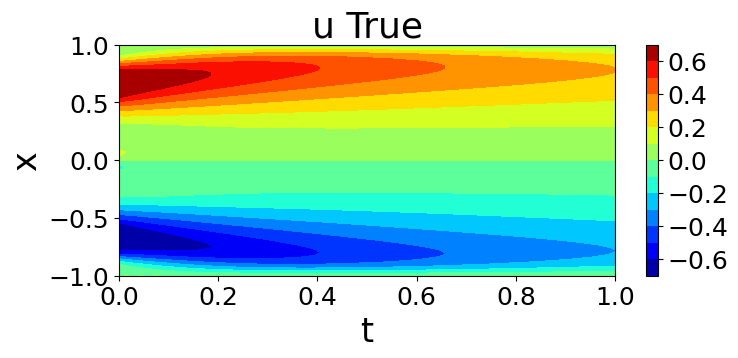

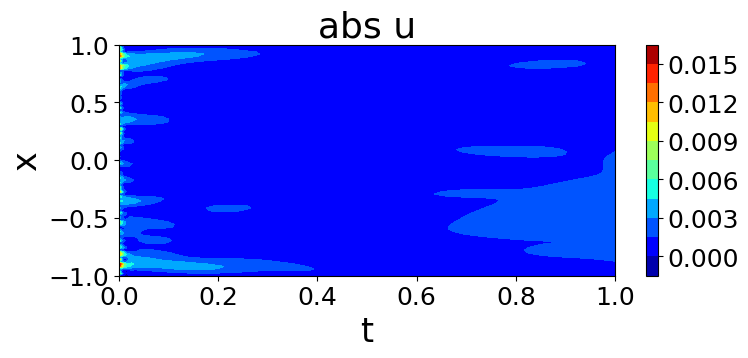

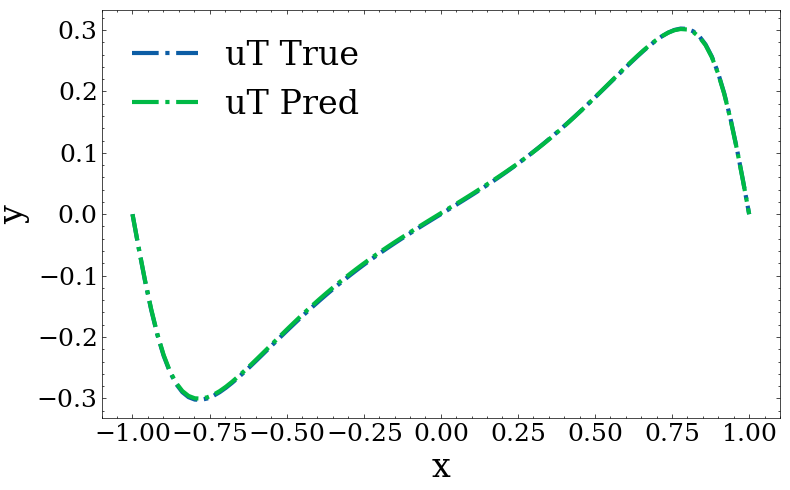

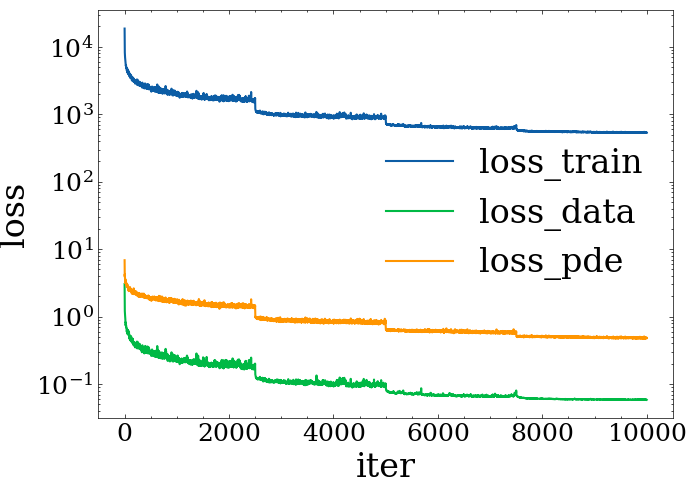

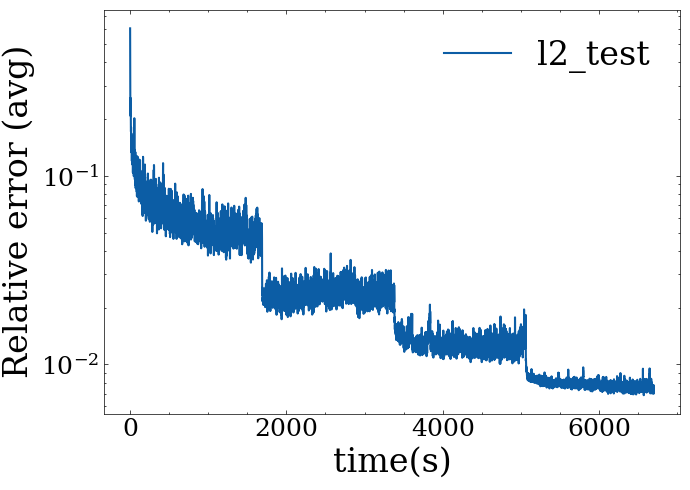

In [3]:
# #####################################
# # Load the trained model
# #####################################
from Solvers.PIMultiONet import PIMultiONet
solver = PIMultiONet.Solver(device=device, dtype=dtype)
tag = 'tanhBeta64_TS'
model_trained = solver.loadModel(path=f'saved_models/PI{netType}_{tag}/', name=f'model_pimultionet_final')
########################################
xt_test = gridxt_test.repeat(u_test.shape[0], 1, 1).to(device)
beta = model_trained['enc'](a_test.to(device))
u_pred = model_trained['u'](xt_test, beta)
u_pred = mollifer()(u_pred, xt_test).detach().cpu()
#########################################
xt_end_test = xt_end.repeat(uT_test.shape[0], 1, 1).to(device)
beta = model_trained['enc'](a_test.to(device))
uT_pred = model_trained['u'](xt_end_test, beta)
uT_pred = mollifer()(uT_pred, xt_end_test).detach().cpu()
#
print('The shape of a_test:', a_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of u_pred:', u_pred.shape)
print('The test loss (avg):', solver.getLoss(u_pred, u_test))
print('The test l2 error (avg):', solver.getError(u_pred, u_test))
#
inx = 5
# # # ########################################
from Utils.PlotFigure import Plot
Plot.show_1dt(gridxt_test, u_pred[inx], title='u True', tT=1.)
Plot.show_1dt(gridxt_test, torch.abs(u_pred[inx]-u_test[inx]), title='abs u', tT=1.)
Plot.show_1d_list(x_test[inx], [uT_test[inx], uT_pred[inx]], ['uT True', 'uT Pred'], lb=-1.)
# #############################################
# show loss
loss_saved = solver.loadLoss(path=f'saved_models/PI{netType}_{tag}/', name='loss_pimultionet')
Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_data'], loss_saved['loss_pde']], 
               ['loss_train', 'loss_data', 'loss_pde'])
# show error
Plot.show_error([loss_saved['time']]*1, [loss_saved['error']], ['l2_test'])